In [1]:
import networkx as nx
import string
from sys import maxint
import pandas as pd
import numpy as np
import time
import re
import os.path
import math

In [2]:
#num_documents: number of documents
#clean_train_documents: the collection
#unique_words: list of all the words we found 
#sliding_window: window size
#train_par: if true we are in the training documents
#idf_learned
def createGraphFeatures(num_documents,clean_train_documents,unique_words,sliding_window,train_par,idf_learned):
	features = np.zeros((num_documents,len(unique_words)))#where we are going to put the features
	unique_words_len = len(unique_words)
	term_num_docs = {} #dictionay of each word with a count of that word through out the collections
	idf_col = {}#dictionay of each word with the idf of that word
	
	#TO DO:
	#1.idf_col:IDF for the collection
	#	if in training phase compute it
	#	else use the one provided
	#2. term_num_docs : count of the words in the collection
	#	if in training phase populate it
	#	else use the one provided
	if train_par:
		
		#for all documents
		for i in range( 0,num_documents ):
			wordList1 = clean_train_documents[i].split(None)
			wordList2 = [string.rstrip(x.lower(), ',.!?;') for x in wordList1]
			#count word occurrences through the collection (for idf) put the count in term_num_docs
			if len(wordList2)>1:
				countWords(wordList2,term_num_docs) #TODO: implement this function 
		#TODO: calculate the idf for all words
		for term_x in term_num_docs:
			idf_col[term_x] = math.log10(float(num_documents)/term_num_docs[term_x])            
	# for the testing set
	else:
		#use the existing ones if we are in the test data
		idf_col = idf_learned 
		term_num_docs=unique_words

	print "Creating the graph of words for each document..."
	totalNodes = 0
	totalEdges = 0

	#go over all documents
	for i in range( 0,num_documents ):
		wordList1 = clean_train_documents[i].split(None)
		wordList2 = [string.rstrip(x.lower(), ',.!?;') for x in wordList1]
		docLen = len(wordList2)
		#the graph
		dG = nx.Graph()

		if len(wordList2)>1:
			populateGraph(wordList2,dG,sliding_window)
			dG.remove_edges_from(dG.selfloop_edges())
			centrality = nx.degree_centrality(dG) #dictionary of centralities (node:degree)

			totalNodes += dG.number_of_nodes()
			totalEdges += dG.number_of_edges()

			
			#TODO : implement comments bellow
			# for all nodes
				#If they are in the desired features
					#compute the TW-IDF score and put it in features[i,unique_words.index(g)]
			for k, node_term in enumerate(dG.nodes()):
				if node_term in idf_col:
					features[i,unique_words.index(node_term)] = centrality[node_term] * idf_col[node_term]

	if train_par:
		nodes_ret=term_num_docs.keys()
		#print "Percentage of features kept:"+str(feature_reduction)
		print "Average number of nodes:"+str(float(totalNodes)/num_documents)
		print "Average number of edges:"+str(float(totalEdges)/num_documents)
	else:
		nodes_ret=term_num_docs
	#return 1: features, 2: idf values (for the test data), 3: the list of terms 
	return features, idf_col, nodes_ret

In [3]:
def populateGraph(wordList,dG,sliding_window):
	#TODO: implement this function
	#For each position/word in the word list:
		#add the -new- word in the graph
		#for all words -forward- within the window size
			#add new words as new nodes 
			#add edges among all word within the window
	for k, word in enumerate(wordList):
		if not dG.has_node(word):
			dG.add_node(word)
		tempW=sliding_window
		if k+sliding_window > len(wordList):
			tempW=len(wordList) - k
		for j in xrange(1, tempW):
			next_word = wordList[k+j]
			dG.add_edge(word, next_word)

In [4]:
def countWords(wordList,term_num_docs):
	found = set()
	#TODO: implement this function
	#add the terms from the wordlist to the term_num_docs dictionary or increase its count
	for k, word in enumerate(wordList):
		if word not in found:
			found.add(word)
			if word in term_num_docs:
				term_num_docs[word] +=1
			else :
				term_num_docs[word] = 1

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import numpy as np
from sklearn import svm
import time
import string
import math
from sklearn.metrics import roc_curve, auc

In [6]:
#function needed to convert distances to probabilities

def predict_proba(X,model):
	f = np.vectorize(lambda x: 1/(1+np.exp(-x)))
	raw_predictions = model.decision_function(X)
	platt_predictions = f(raw_predictions)
	probs = platt_predictions / platt_predictions.sum(axis=1)[:, None]
	return probs

In [7]:
%matplotlib inline

In [8]:
#parameters for graph of words
sliding_window = 2
#a dictionary with all  the idfs (needed for the tw-idf)
idfs = {}

In [11]:
# the labelled training data
cols = ['class', 'text']
train = pd.read_csv("/Users/Flukmacdesof/projet-MAP-670/Graph_of_words_TD/data/r8-train-stemmed.txt", sep="\t", header=None, names=cols)

print train.shape

(5485, 2)


In [12]:
# num of docs= rows
num_documents = train.shape[0]

clean_train_documents=train['text'].values

#use pandas 'magic' to get a list of words from all documents and then get the set of unique words
unique_words=list(set(train['text'].str.split(' ').apply(pd.Series,1).stack().values))
print "Unique words:"+str(len(unique_words))

print "Building features..."

Unique words:14575
Building features...


In [13]:
#tf-idf features on train data
start = time.time()
'''fit_transform() does two functions: First, it fits the model
and learns the vocabulary; second, it transforms our training data
into feature vectors. The input to fit_transform should be a list of strings.
train_data_features = vectorizer.fit_transform(clean_train_documents)'''
tfidf_vect = TfidfVectorizer(analyzer = "word",lowercase= True,norm=None )
#features = tfidf_vect.fit_transform(clean_train_documents)

#tw-idf features on train data
features, idfs_learned, nodes= createGraphFeatures(num_documents,clean_train_documents,unique_words,sliding_window,True,idfs)
end = time.time()
print "Total time to build features:\t"+str(end - start)

print "Training the classifier..."
start = time.time()


clf = svm.LinearSVC(loss="hinge")
Y = train['class']
#build a dictionary to assign numerical values to class labels
class_to_num={}
classLabels=train['class'].unique()

for i,val in enumerate(classLabels):
	class_to_num[val]=i
print "Class correspondence"	
print class_to_num
#map the values of the class to the numbers
y=train['class'].map(class_to_num).values

print "Number of classes:"+str(len(classLabels))
model = clf.fit( features, y )
end = time.time()
print "Total time to train classifier:\t"+str(end - start)

##################

Creating the graph of words for each document...
Average number of nodes:41.1965360073
Average number of edges:57.3998176846
Total time to build features:	124.891871929
Training the classifier...
Class correspondence
{'earn': 0, 'money-fx': 7, 'trade': 2, 'acq': 1, 'grain': 4, 'interest': 6, 'crude': 5, 'ship': 3}
Number of classes:8
Total time to train classifier:	2.99523711205


In [15]:
## Testing set
test = pd.read_csv("/Users/Flukmacdesof/projet-MAP-670/Graph_of_words_TD/data/r8-test-stemmed.txt", sep="\t", header=None, names=cols)

print test.shape

# Get the number of documents based on the data frame column size
num_test_documents = test.shape[0]
clean_test_documents = test['text'].values

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool. 
print "Creating features for test set"

# Careful: here we use transform and not fit_transform
#features_test = tfidf_vect.transform(clean_test_documents)
#similar to tw-idf
features_test,idfs,nodes = createGraphFeatures(num_test_documents,clean_test_documents,nodes,sliding_window,False,idfs_learned)


#map the values of the class to the numbers
y_test=test['class'].map(class_to_num).values
lb = preprocessing.LabelBinarizer()
lb.fit(np.arange(len(classLabels)))
y_test_vector=lb.transform(y_test)
pred_test = model.predict(features_test)

met = metrics.classification_report(y_test, pred_test, target_names=classLabels, digits=4)
print met

probs = predict_proba(features_test,model) 
	
precision, recall, threshold = metrics.precision_recall_curve(y_test_vector.ravel(),probs.ravel())

(2189, 2)
Creating features for test set
Creating the graph of words for each document...
             precision    recall  f1-score   support

       earn     0.9899    0.9935    0.9917      1083
        acq     0.9759    0.9871    0.9814       696
      trade     0.9024    0.9867    0.9427        75
       ship     0.9688    0.8611    0.9118        36
      grain     1.0000    0.9000    0.9474        10
      crude     0.9741    0.9339    0.9536       121
   interest     0.9342    0.8765    0.9045        81
   money-fx     0.9277    0.8851    0.9059        87

avg / total     0.9767    0.9767    0.9765      2189



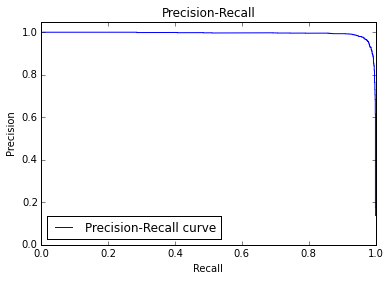

In [16]:
plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall')
plt.legend(loc="lower left")
plt.show()